<a href="https://colab.research.google.com/github/kd610/face-mask-detector/blob/master/training_on_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=ecee4731445e49dc5cfc4138a0a5c7b6b33bacc76f07f339ddcb44a9491cb723
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 158.6 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [1]:
!git clone https://github.com/kd610/face-mask-detector.git

Cloning into 'face-mask-detector'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 97514 (delta 4), reused 13 (delta 3), pack-reused 97499
Receiving objects: 100% (97514/97514), 803.31 MiB | 21.54 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Checking out files: 100% (99872/99872), done.


In [1]:
!ls

adc.json  face-mask-detector  sample_data


In [1]:
# USAGE
# python train_mask_detector.py --dataset dataset

# import the necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [3]:
!pip show httplib2

Name: httplib2
Version: 0.15.0
Summary: A comprehensive HTTP client library.
Home-page: https://github.com/httplib2/httplib2
Author: Joe Gregorio
Author-email: joe@bitworking.org
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: 
Required-by: oauth2client, httplib2shim, google-auth-httplib2, google-api-python-client, earthengine-api


In [5]:
!pip uninstall httplib2
!pip install httplib2==0.15.0

Uninstalling httplib2-0.17.4:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/httplib2-0.17.4.dist-info/*
    /usr/local/lib/python3.6/dist-packages/httplib2/*
Proceed (y/n)? y
  Successfully uninstalled httplib2-0.17.4
     |████████████████████████████████| 102kB 5.8MB/s 
ERROR: google-api-python-client 1.7.12 has requirement httplib2<1dev,>=0.17.0, but you'll have httplib2 0.15.0 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [18]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 30
BS = 32

In [5]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images("./face-mask-detector/dataset"))
data = []
labels = []

[INFO] loading images...


In [6]:
# loop over the image paths
for imagePath in imagePaths:
  #print(imagePath)
	#extract the class label from the filename
  label = imagePath.split(os.path.sep)[-2]

	#load the input image (224x224) and preprocess it
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)
  image = preprocess_input(image) #Convert to the range [-1, 1]

	# update the data and labels lists, respectively
  data.append(image)
  labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [9]:
len(data)

7188

In [10]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
#(trainX, testX, trainY, testY) = train_test_split(data, labels,
#	test_size=0.15, stratify=labels, random_state=42)

In [7]:

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, tmpX, trainY, tmpY) = train_test_split(data, labels,
	test_size=0.30, stratify=labels, random_state=42)


In [8]:
(validX, testX, validY, testY) = train_test_split(tmpX, tmpY,
	test_size=0.50, stratify=tmpY, random_state=42)

In [11]:
import gc
del data, labels
gc.collect()

11

In [12]:
print('The number of images in Training dataset is ', len(trainX)) #70%
print('The number of images in Validation dataset is ', len(validX)) #15%
print('The number of images in Test dataset is ', len(testX)) #15%


The number of images in Training dataset is  5031
The number of images in Validation dataset is  1078
The number of images in Test dataset is  1079


In [14]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [15]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = NASNetMobile(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [19]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = True

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [23]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [24]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(validX, validY),
	validation_steps=len(validX) // BS,
	epochs=EPOCHS,
	verbose=1, 
	callbacks=[es, mc])

[INFO] training head...
Epoch 1/30
157/157 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9990
Epoch 00001: val_accuracy improved from -inf to 0.99629, saving model to best_model.h5
157/157 [==============================] - 88s 559ms/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.0191 - val_accuracy: 0.9963
Epoch 2/30
157/157 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9992
Epoch 00002: val_accuracy improved from 0.99629 to 0.99722, saving model to best_model.h5
157/157 [==============================] - 88s 560ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0174 - val_accuracy: 0.9972
Epoch 3/30
157/157 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9996
Epoch 00003: val_accuracy did not improve from 0.99722
157/157 [==============================] - 86s 548ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.0227 - val_accuracy: 0.9963
Epoch 4/30
157/157 [==============================] - 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Unrecognized location 'Upper left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if __name__ == '__main__':


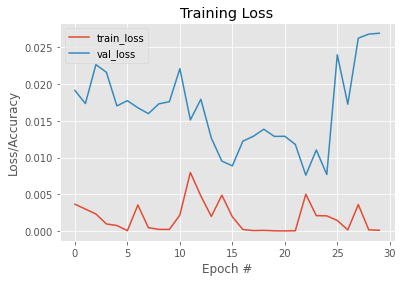

In [25]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="Upper left")


Text(0.5, 1.0, 'Training Accuracy')

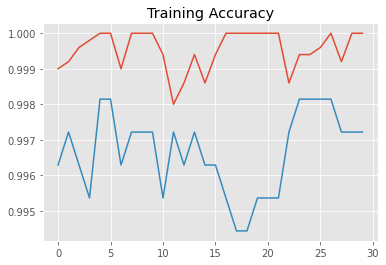

In [26]:
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")

In [31]:
test_loss, test_acc = model.evaluate(testX,  testY, verbose=1)

34/34 [==============================] - 3s 91ms/step - loss: 0.0084 - accuracy: 0.9981


In [102]:
print('\nTest accuracy:', test_acc)
print('\nTest Loss:', test_loss)


Test accuracy: 0.9981464147567749

Test Loss: 0.008411357179284096


In [98]:
class_names = ['with mask', 'without mask']

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(2))
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [100]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [78]:
testY = testY.astype(int)
testY

array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [95]:
test_labels = []
for t in testY:
  if t[0] == 0:
      test_labels.append(1)
  else:
      test_labels.append(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

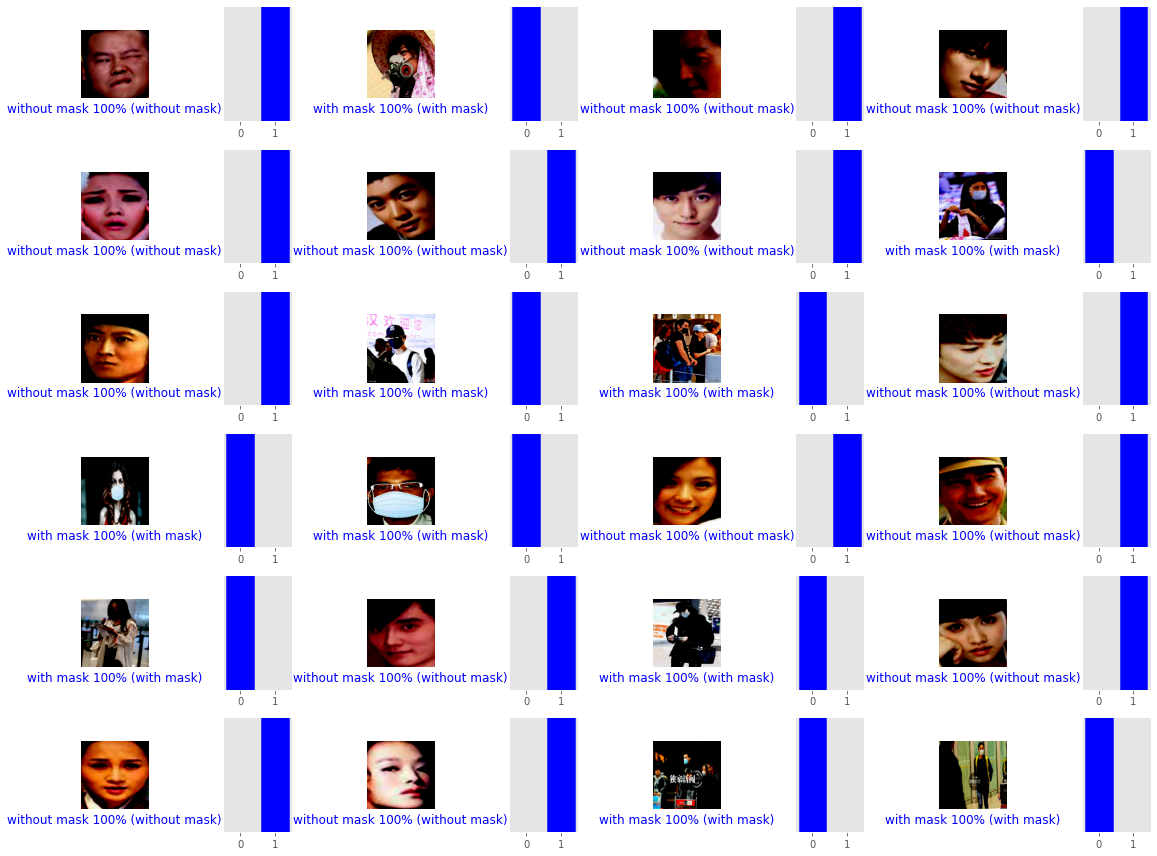

In [101]:
num_rows = 6
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predIdxs[i], test_labels, testX)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predIdxs[i], test_labels)
plt.tight_layout()
plt.show()

In [ ]:
predIdxs = np.argmax(predIdxs)

In [103]:
print("[INFO] saving mask detector model...")
model.save("Nasnet_mobile_v2_with_valid_dataset.h5")

[INFO] saving mask detector model...


In [104]:
uploaded = drive.CreateFile({'title': 'Nasnet_mobile_v2_with_valid_dataset.h5'})
uploaded.SetContentFile('./Nasnet_mobile_v2_with_valid_dataset.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1hWE5BwpaNzlF2OFcmgnqB1cg3Qw1lBvH


In [ ]:
trainX

NameError: ignored